In [2]:
import pandas as pd
df = pd.read_csv('/Users/carlitos/Desktop/ProteinDesign/ProteinDesign/pdb_data_seq.csv')

In [3]:
print(df.columns)

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')


In [4]:
protein_seq = df.query('macromoleculeType == "Protein"')['sequence']
print(protein_seq)

4         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                                ...                        
467299    MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
467300    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467301    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467302    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467303    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
Name: sequence, Length: 345180, dtype: object


In [5]:
# we only need 20k protein sequences
protein_seq = protein_seq[:20000].reset_index(drop=True)
print(protein_seq)

0        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                               ...                        
19995    MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...
19996    MNPDLRKERASATFNPELITHILDGSPENTRRRREIENLILNDPDF...
19997    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
19998    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
19999    SDRAEVRNIPFKLGMYLTVGGVVNSNATRFSINVGESTDSIAMHMD...
Name: sequence, Length: 20000, dtype: object


In [6]:
# check nan values
protein_seq.isna().sum()

np.int64(1)

In [7]:
# drop nan
protein_seq = protein_seq.dropna()
len(protein_seq)

19999

In [8]:
# convert to list of protein sequences
proteins = protein_seq.tolist()
proteins[:3]

['MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG',
 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
 'MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG']

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# build a vocabulary of mapping the aa to integers
aa = list(set(''.join(proteins)))
stoi = {s:i+1 for i,s in enumerate(aa)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'D', 2: 'K', 3: 'P', 4: 'Q', 5: 'H', 6: 'R', 7: 'L', 8: 'G', 9: 'N', 10: 'F', 11: 'Z', 12: 'U', 13: 'W', 14: 'Y', 15: 'T', 16: 'M', 17: 'E', 18: 'X', 19: 'C', 20: 'I', 21: 'S', 22: 'V', 23: 'A', 0: '.'}
24


In [27]:
# let's build the dataset
block_size = 3 # context length

def build_dataset(proteins):
  X, Y = [], []

  for protein in proteins:
    #print(protein)
    context = [0] * block_size
    for aa in protein + '.':
      ix = stoi[aa]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])      # 80%
Xdev, Ydev = build_dataset(proteins[n1:n2])  # 10%
Xte, Yte = build_dataset(proteins[n2:])      # 10%

torch.Size([3799190, 3]) torch.Size([3799190])
torch.Size([469943, 3]) torch.Size([469943])
torch.Size([475834, 3]) torch.Size([475834])


In [ ]:
n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, n_emb),             generator=g)
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g) * (5/3)/((n_emb * block_size)**0.5)
#b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01
b2 = torch.randn(vocab_size,                     generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True


11664


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch x, batch y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + bnbias)
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01 if i < 100000 else 0.001
  #lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log().item())

#print(loss.item())

      0/ 200000: 3.2159
  10000/ 200000: 2.7173
  20000/ 200000: 3.0422
  30000/ 200000: 2.9403
  40000/ 200000: 3.1045
  50000/ 200000: 2.7568
  60000/ 200000: 2.9264
  70000/ 200000: 2.9902
  80000/ 200000: 2.8004
  90000/ 200000: 2.8403
 100000/ 200000: 2.7790
 110000/ 200000: 2.7678
 120000/ 200000: 2.7582
 130000/ 200000: 2.9383
 140000/ 200000: 2.8099
 150000/ 200000: 2.9960
 160000/ 200000: 2.8577
 170000/ 200000: 2.9311
 180000/ 200000: 2.9273
 190000/ 200000: 2.9895


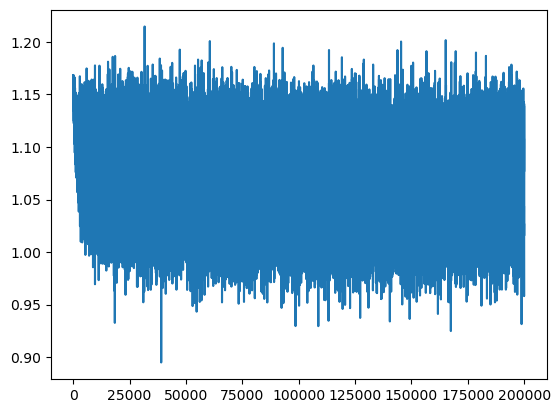

In [36]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.892559051513672
val 2.8874809741973877


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(17)

for _ in range(3):

  out = []
  context = [0] * block_size
  while True:
    # forward pass of the neural net
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated protein

MNPYALSMTDVLAAAGESGILLKSTAYSNQTAQKVFEEWPIFPTSAFNDSGQEEGTATSAASVVPIEQKRIGHGIKIAAYALSELGGVNLREFDKGFFNKLVAPRDKLADVPTKPTALDNAIKNQDKAPKDTAAQTMADISLKEVAAKFLDRGEKITNIKPPRFVVVLFYERLCTEEDRGRKATVSCN.
SFETFKIHNKGVFLLDREIFSTYENDALIGTCLTINPAYKQIIHKMHEWKIRPNPKYAEKDERAFFDKMEEKAVLETPKVAPTSQGLCDLTESIIEATLDEAFVAGSTLKFLIGTYGGTTCLKGNKLLGRANSTKKVDSYPIHTRAVLAEKAVLTTPWSGNTPRAIWVNTVWPRTCILLSQFHNSILNYEISNAGIEGSKVHELIRQLLGSEARAAVLSVQADRRSCLVRARTILDIKHNAIPEYTPGGLTGHLLAFLRRRPFWSVATKRIHEIWKYGREIWNLIEVKSGSPV.
IAPARHEVDANVLPTWNIIWGREINERDLVQGKKLFKAWVFPKGAGNHIGTYGYYLPLEIPCRGNVEIKTGTQAVEPPPGETIMHLYLYDNRNTACYFTSCPYSTNAFPPDTQQHEAVGKIGLRSCCNAKIRYHPSEKGTDGHREFNGRPFRAGAQQNCMIAPRMLNPFYPDNSHIYNAWLLTR.


# Let's PyTorchify the code

In [93]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(47) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


46688


In [94]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.1904


layer 2 (      Tanh): mean +0.01, std 0.63, saturated: 3.12%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.53%
layer 8 (      Tanh): mean +0.00, std 0.63, saturated: 3.09%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.75%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 2.81%


Text(0.5, 1.0, 'activation distribution')

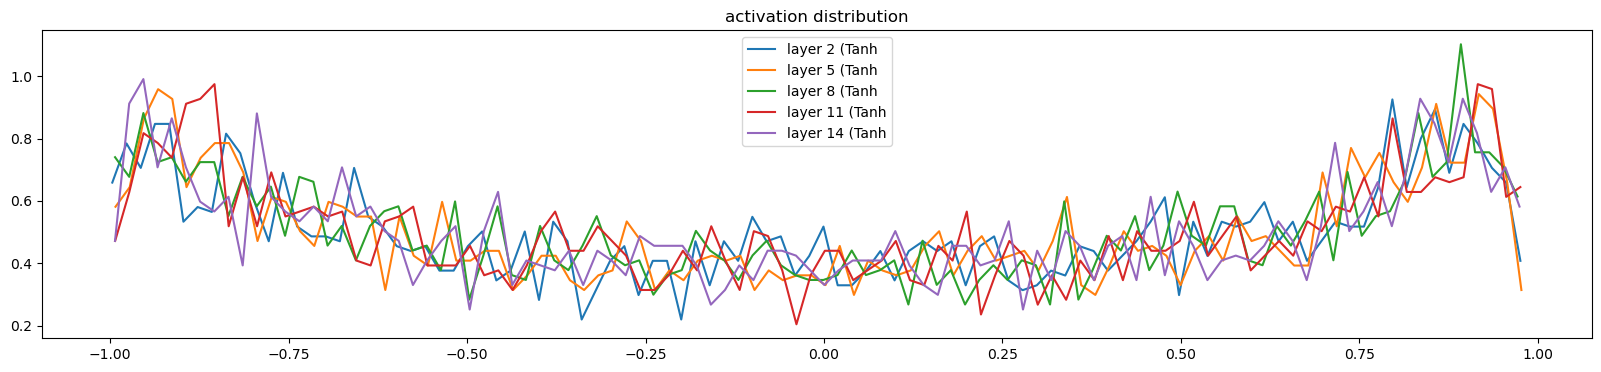

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.570932e-04
layer 5 (      Tanh): mean +0.000000, std 2.248388e-04
layer 8 (      Tanh): mean +0.000000, std 2.222068e-04
layer 11 (      Tanh): mean -0.000000, std 1.966198e-04
layer 14 (      Tanh): mean +0.000000, std 1.777075e-04


Text(0.5, 1.0, 'gradient distribution')

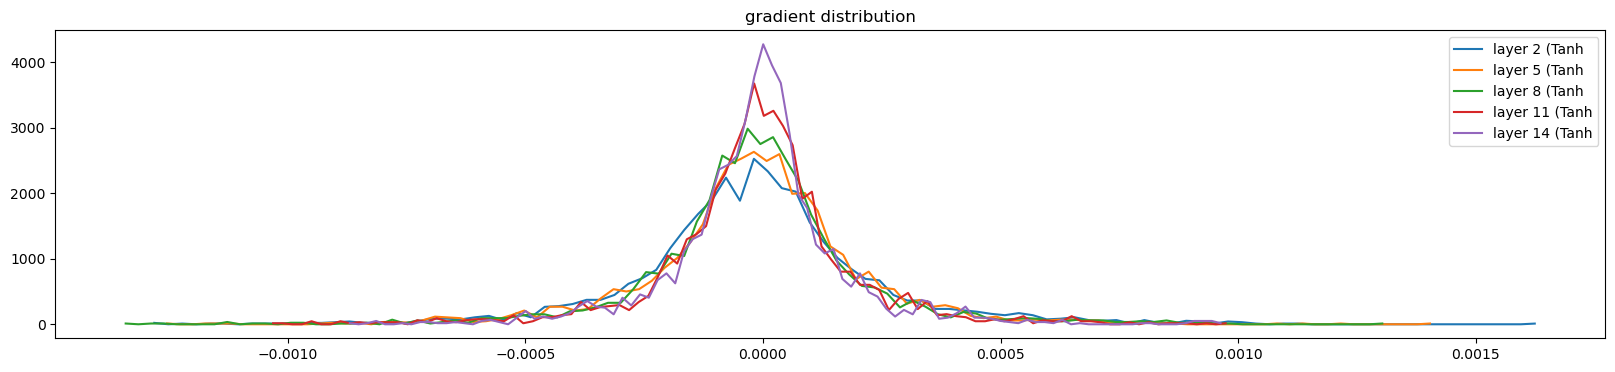

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (24, 10) | mean +0.000000 | std 5.766713e-04 | grad:data ratio 5.853854e-04
weight  (30, 100) | mean -0.000000 | std 3.307134e-05 | grad:data ratio 6.107834e-06
weight (100, 100) | mean +0.000000 | std 8.824913e-06 | grad:data ratio 8.865315e-07
weight (100, 100) | mean -0.000000 | std 8.454375e-06 | grad:data ratio 8.377228e-07
weight (100, 100) | mean -0.000000 | std 7.851432e-06 | grad:data ratio 7.830550e-07
weight (100, 100) | mean +0.000000 | std 6.839444e-06 | grad:data ratio 6.811032e-07
weight  (100, 24) | mean +0.000000 | std 1.307309e-05 | grad:data ratio 1.284447e-06


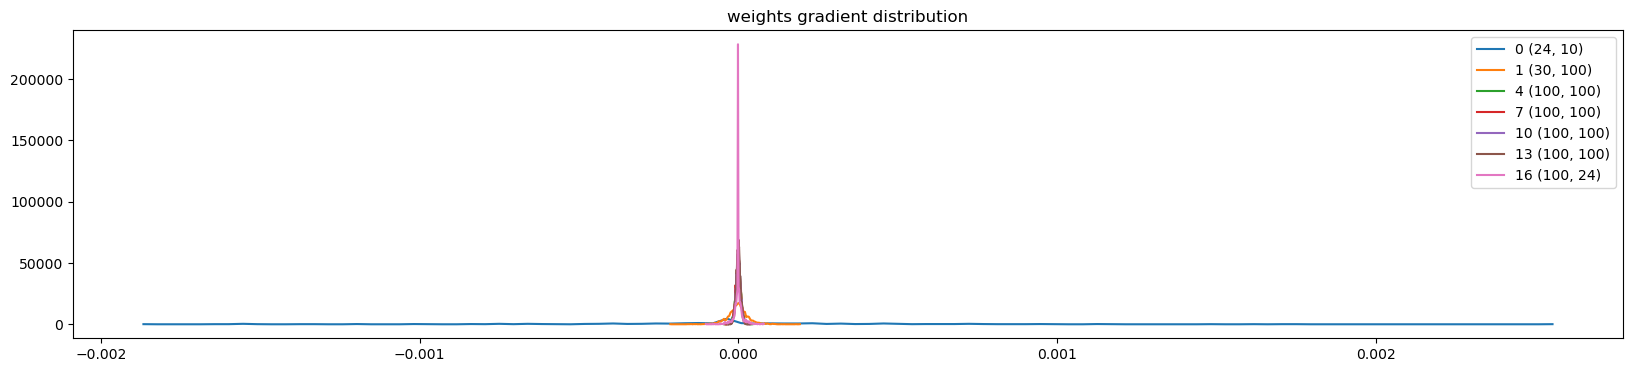

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

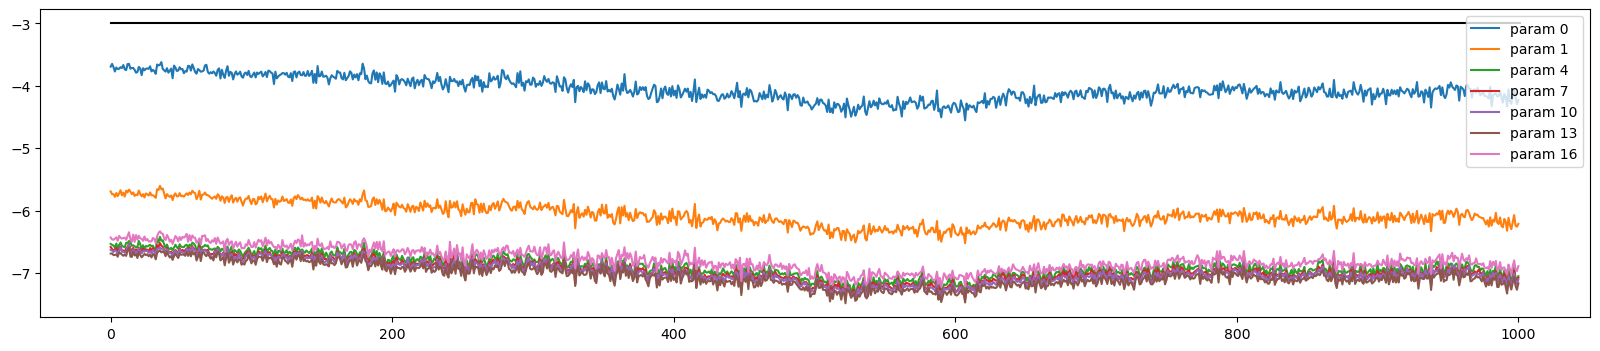

In [98]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [45]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.946584939956665
val 2.950099229812622


# Doing backprop manually

In [99]:
# let's build the dataset
block_size = 3 # context length

def build_dataset(proteins):
  X, Y = [], []

  for protein in proteins:
    #print(protein)
    context = [0] * block_size
    for aa in protein + '.':
      ix = stoi[aa]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])      # 80%
Xdev, Ydev = build_dataset(proteins[n1:n2])  # 10%
Xte, Yte = build_dataset(proteins[n2:])      # 10%

torch.Size([3806492, 3]) torch.Size([3806492])
torch.Size([474937, 3]) torch.Size([474937])
torch.Size([463538, 3]) torch.Size([463538])


In [100]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [101]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

3912


In [102]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [103]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.2743, grad_fn=<NegBackward0>)

In [122]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
dprobs = (1 / probs) * dlogprobs
dcounts_sum_inv = (dprobs * counts).sum(1, keepdims=True)
dcounts = dprobs * counts_sum_inv
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = (counts) * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [123]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.274329423904419 diff: 0.0


In [131]:
logits.shape, Yb.shape

dlogits = torch.zeros_like(logits)
dlogits.shape

torch.Size([32, 24])

In [134]:
# backward pass

dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09
